In [1]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
import polars as pl
import joblib

history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq_train = build_history_seq(history_train, articles)

2024-06-19 07:29:16.045261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 07:29:16.099055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 07:29:16.774785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ner_features = pl.read_parquet('/home/ubuntu/preprocessing/urm_ner_scores/ebnerd_small/train/urm_ner_scores.parquet')
ner_features

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores
u32,u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778623,0.205654,0.572521,78.457352,7.075347,0.20138,0.200239,0.550502,72.221519,7.197525,0.20138,0.01582,0.04404,6.035181,0.544258,0.015491
149474,139836,9778682,0.002835,0.015383,2.759468,-1.845374,0.0,0.002835,0.01331,2.430749,2.256506,0.0,0.000315,0.001709,0.306608,-0.205042,0.0
149474,139836,9778669,0.042866,0.07184,15.371393,-1.558742,0.001299,0.042866,0.071768,15.369935,2.275229,0.001299,0.007144,0.011973,2.561899,-0.25979,0.000216
149474,139836,9778657,0.850125,2.778531,343.839874,45.888317,0.69546,0.195003,0.572702,75.460228,7.77542,0.232465,0.077284,0.252594,31.258171,4.171665,0.063224
149474,139836,9778736,0.399057,1.220464,157.837952,18.20508,0.437944,0.195003,0.572702,75.460228,7.77542,0.232465,0.033255,0.101705,13.153163,1.51709,0.036495
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
580100697,2110744,9771042,0.671621,1.241233,306.360626,5.598816,0.291323,0.652423,1.039263,277.178955,4.335356,0.290659,0.223874,0.413744,102.120209,1.866272,0.097108
580100697,2110744,9514481,1.400546,2.244725,619.133362,7.054404,1.116744,1.399633,2.228862,614.669739,7.885966,1.116744,0.466849,0.748241,206.377792,2.351468,0.372248
580100697,2110744,9440508,1.271307,2.035379,588.304749,6.646263,0.767379,1.238742,2.007053,583.609802,6.569769,0.762803,0.635653,1.017689,294.152374,3.323131,0.383689


In [3]:
ner_cols = [col for col in ner_features.columns if col not in ['impression_id', 'user_id', 'article']]
NORMALIZE_OVER_IMPRESSION_ID = ner_cols
ner_features = ner_features.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('user_id'))).alias(f'{c}_minus_median_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
)
ner_features.head(1)

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores,sum_RP3betaRecommender_ner_scores_l_inf_impression,sum_PureSVDItemRecommender_ner_scores_l_inf_impression,sum_ItemKNNCFRecommender_ner_scores_l_inf_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,sum_P3alphaRecommender_ner_scores_l_inf_impression,max_RP3betaRecommender_ner_scores_l_inf_impression,max_PureSVDItemRecommender_ner_scores_l_inf_impression,max_ItemKNNCFRecommender_ner_scores_l_inf_impression,max_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,max_P3alphaRecommender_ner_scores_l_inf_impression,mean_RP3betaRecommender_ner_scores_l_inf_impression,mean_PureSVDItemRecommender_ner_scores_l_inf_impression,mean_ItemKNNCFRecommender_ner_scores_l_inf_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,mean_P3alphaRecommender_ner_scores_l_inf_impression,sum_RP3betaRecommender_ner_scores_minus_median_impression,sum_PureSVDItemRecommender_ner_scores_minus_median_impression,sum_ItemKNNCFRecommender_ner_scores_minus_median_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,sum_P3alphaRecommender_ner_scores_minus_median_impression,max_RP3betaRecommender_ner_scores_minus_median_impression,max_PureSVDItemRecommender_ner_scores_minus_median_impression,max_ItemKNNCFRecommender_ner_scores_minus_median_impression,max_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,max_P3alphaRecommender_ner_scores_minus_median_impression,mean_RP3betaRecommender_ner_scores_minus_median_impression,mean_PureSVDItemRecommender_ner_scores_minus_median_impression,mean_ItemKNNCFRecommender_ner_scores_minus_median_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,mean_P3alphaRecommender_ner_scores_minus_median_impression
u32,u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778623,0.205654,0.572521,78.457352,7.075347,0.20138,0.200239,0.550502,72.221519,7.197525,0.20138,0.01582,0.04404,6.035181,0.544258,0.015491,0.158916,0.154656,0.165669,0.101319,0.175334,0.928003,0.943342,0.945233,0.899902,0.824406,0.110019,0.10707,0.114694,0.094798,0.121385,-0.095517,-0.421829,-38.798653,-11.459299,-0.031085,0.046543,0.065922,7.809608,1.075384,0.058168,-0.014182,-0.051971,-5.92063,-1.388489,-0.004056


In [4]:
ner_features

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores,sum_RP3betaRecommender_ner_scores_l_inf_impression,sum_PureSVDItemRecommender_ner_scores_l_inf_impression,sum_ItemKNNCFRecommender_ner_scores_l_inf_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,sum_P3alphaRecommender_ner_scores_l_inf_impression,max_RP3betaRecommender_ner_scores_l_inf_impression,max_PureSVDItemRecommender_ner_scores_l_inf_impression,max_ItemKNNCFRecommender_ner_scores_l_inf_impression,max_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,max_P3alphaRecommender_ner_scores_l_inf_impression,mean_RP3betaRecommender_ner_scores_l_inf_impression,mean_PureSVDItemRecommender_ner_scores_l_inf_impression,mean_ItemKNNCFRecommender_ner_scores_l_inf_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,mean_P3alphaRecommender_ner_scores_l_inf_impression,sum_RP3betaRecommender_ner_scores_minus_median_impression,sum_PureSVDItemRecommender_ner_scores_minus_median_impression,sum_ItemKNNCFRecommender_ner_scores_minus_median_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,sum_P3alphaRecommender_ner_scores_minus_median_impression,max_RP3betaRecommender_ner_scores_minus_median_impression,max_PureSVDItemRecommender_ner_scores_minus_median_impression,max_ItemKNNCFRecommender_ner_scores_minus_median_impression,max_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,max_P3alphaRecommender_ner_scores_minus_median_impression,mean_RP3betaRecommender_ner_scores_minus_median_impression,mean_PureSVDItemRecommender_ner_scores_minus_median_impression,mean_ItemKNNCFRecommender_ner_scores_minus_median_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,mean_P3alphaRecommender_ner_scores_minus_median_impression
u32,u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
149474,139836,9778623,0.205654,0.572521,78.457352,7.075347,0.20138,0.200239,0.550502,72.221519,7.197525,0.20138,0.01582,0.04404,6.035181,0.544258,0.015491,0.158916,0.154656,0.165669,0.101319,0.175334,0.928003,0.943342,0.945233,0.899902,0.824406,0.110019,0.10707,0.114694,0.094798,0.121385,-0.095517,-0.421829,-38.798653,-11.459299,-0.031085,0.046543,0.065922,7.809608,1.075384,0.058168,-0.014182,-0.051971,-5.92063,-1.388489,-0.004056
149474,139836,9778682,0.002835,0.015383,2.759468,-1.845374,0.0,0.002835,0.01331,2.430749,2.256506,0.0,0.000315,0.001709,0.306608,-0.205042,0.0,0.002191,0.004156,0.005827,-0.026426,0.0,0.01314,0.022808,0.031814,0.28213,0.0,0.002191,0.004156,0.005827,-0.035714,0.0,-0.298336,-0.978966,-114.496536,-20.38002,-0.232465,-0.150861,-0.47127,-61.981163,-3.865635,-0.143212,-0.029686,-0.094302,-11.649204,-2.137789,-0.019547
149474,139836,9778669,0.042866,0.07184,15.371393,-1.558742,0.001299,0.042866,0.071768,15.369935,2.275229,0.001299,0.007144,0.011973,2.561899,-0.25979,0.000216,0.033124,0.019406,0.032458,-0.022321,0.001131,0.19866,0.122982,0.201161,0.284471,0.005316,0.049686,0.029109,0.048687,-0.04525,0.001696,-0.258305,-0.922509,-101.884613,-20.09339,-0.231166,-0.11083,-0.412812,-49.041977,-3.846911,-0.141913,-0.022857,-0.084038,-9.393912,-2.192537,-0.019331
149474,139836,9778657,0.850125,2.778531,343.839874,45.888317,0.69546,0.195003,0.572702,75.460228,7.77542,0.232465,0.077284,0.252594,31.258171,4.171665,0.063224

In [5]:
import gc
from pathlib import Path
train_ds = pl.read_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet')

train_ds = train_ds.join(ner_features, on=['user_id', 'impression_id', 'article'], how='left')

tmp_dir = Path('/home/ubuntu/tmp_dataset/ner')
tmp_dir.mkdir(exist_ok=True, parents=True)
train_ds.write_parquet('/home/ubuntu/tmp_dataset/ner/train_ds.parquet')

del train_ds
gc.collect()

0

In [8]:
ner_features = pl.read_parquet('/home/ubuntu/preprocessing/urm_ner_scores/ebnerd_small/validation/urm_ner_scores.parquet')
ner_cols = [col for col in ner_features.columns if col not in ['impression_id', 'user_id', 'article']]
NORMALIZE_OVER_IMPRESSION_ID = ner_cols
ner_features = ner_features.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) - pl.col(c).median().over(pl.col('user_id'))).alias(f'{c}_minus_median_impression')
     for c in NORMALIZE_OVER_IMPRESSION_ID],
)
ner_features.head(1)

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores,sum_RP3betaRecommender_ner_scores_l_inf_impression,sum_PureSVDItemRecommender_ner_scores_l_inf_impression,sum_ItemKNNCFRecommender_ner_scores_l_inf_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,sum_P3alphaRecommender_ner_scores_l_inf_impression,max_RP3betaRecommender_ner_scores_l_inf_impression,max_PureSVDItemRecommender_ner_scores_l_inf_impression,max_ItemKNNCFRecommender_ner_scores_l_inf_impression,max_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,max_P3alphaRecommender_ner_scores_l_inf_impression,mean_RP3betaRecommender_ner_scores_l_inf_impression,mean_PureSVDItemRecommender_ner_scores_l_inf_impression,mean_ItemKNNCFRecommender_ner_scores_l_inf_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,mean_P3alphaRecommender_ner_scores_l_inf_impression,sum_RP3betaRecommender_ner_scores_minus_median_impression,sum_PureSVDItemRecommender_ner_scores_minus_median_impression,sum_ItemKNNCFRecommender_ner_scores_minus_median_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,sum_P3alphaRecommender_ner_scores_minus_median_impression,max_RP3betaRecommender_ner_scores_minus_median_impression,max_PureSVDItemRecommender_ner_scores_minus_median_impression,max_ItemKNNCFRecommender_ner_scores_minus_median_impression,max_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,max_P3alphaRecommender_ner_scores_minus_median_impression,mean_RP3betaRecommender_ner_scores_minus_median_impression,mean_PureSVDItemRecommender_ner_scores_minus_median_impression,mean_ItemKNNCFRecommender_ner_scores_minus_median_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,mean_P3alphaRecommender_ner_scores_minus_median_impression
u32,u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
96791,22548,9783865,0.115223,0.204934,12.206129,7.100705,0.045941,0.058898,0.117557,7.473948,3.634891,0.027667,0.009602,0.017078,1.017177,0.591725,0.003828,0.041795,0.028494,0.035285,0.066427,0.014047,0.106007,0.136606,0.111264,0.395129,0.026346,0.023912,0.031329,0.022309,0.072889,0.005712,-0.390724,-0.754472,-53.170715,-7.355003,-0.521301,-0.182665,-0.350842,-23.79521,-3.711773,-0.287221,-0.042147,-0.08117,-5.216683,-1.082506,-0.046345


In [9]:
ner_features

impression_id,user_id,article,sum_RP3betaRecommender_ner_scores,sum_PureSVDItemRecommender_ner_scores,sum_ItemKNNCFRecommender_ner_scores,sum_MatrixFactorization_BPR_Cython_ner_scores,sum_P3alphaRecommender_ner_scores,max_RP3betaRecommender_ner_scores,max_PureSVDItemRecommender_ner_scores,max_ItemKNNCFRecommender_ner_scores,max_MatrixFactorization_BPR_Cython_ner_scores,max_P3alphaRecommender_ner_scores,mean_RP3betaRecommender_ner_scores,mean_PureSVDItemRecommender_ner_scores,mean_ItemKNNCFRecommender_ner_scores,mean_MatrixFactorization_BPR_Cython_ner_scores,mean_P3alphaRecommender_ner_scores,sum_RP3betaRecommender_ner_scores_l_inf_impression,sum_PureSVDItemRecommender_ner_scores_l_inf_impression,sum_ItemKNNCFRecommender_ner_scores_l_inf_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,sum_P3alphaRecommender_ner_scores_l_inf_impression,max_RP3betaRecommender_ner_scores_l_inf_impression,max_PureSVDItemRecommender_ner_scores_l_inf_impression,max_ItemKNNCFRecommender_ner_scores_l_inf_impression,max_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,max_P3alphaRecommender_ner_scores_l_inf_impression,mean_RP3betaRecommender_ner_scores_l_inf_impression,mean_PureSVDItemRecommender_ner_scores_l_inf_impression,mean_ItemKNNCFRecommender_ner_scores_l_inf_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_l_inf_impression,mean_P3alphaRecommender_ner_scores_l_inf_impression,sum_RP3betaRecommender_ner_scores_minus_median_impression,sum_PureSVDItemRecommender_ner_scores_minus_median_impression,sum_ItemKNNCFRecommender_ner_scores_minus_median_impression,sum_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,sum_P3alphaRecommender_ner_scores_minus_median_impression,max_RP3betaRecommender_ner_scores_minus_median_impression,max_PureSVDItemRecommender_ner_scores_minus_median_impression,max_ItemKNNCFRecommender_ner_scores_minus_median_impression,max_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,max_P3alphaRecommender_ner_scores_minus_median_impression,mean_RP3betaRecommender_ner_scores_minus_median_impression,mean_PureSVDItemRecommender_ner_scores_minus_median_impression,mean_ItemKNNCFRecommender_ner_scores_minus_median_impression,mean_MatrixFactorization_BPR_Cython_ner_scores_minus_median_impression,mean_P3alphaRecommender_ner_scores_minus_median_impression
u32,u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
96791,22548,9783865,0.115223,0.204934,12.206129,7.100705,0.045941,0.058898,0.117557,7.473948,3.634891,0.027667,0.009602,0.017078,1.017177,0.591725,0.003828,0.041795,0.028494,0.035285,0.066427,0.014047,0.106007,0.136606,0.111264,0.395129,0.026346,0.023912,0.031329,0.022309,0.072889,0.005712,-0.390724,-0.754472,-53.170715,-7.355003,-0.521301,-0.182665,-0.350842,-23.79521,-3.711773,-0.287221,-0.042147,-0.08117,-5.216683,-1.082506,-0.046345
96791,22548,9784591,0.671722,1.316174,82.170059,19.920918,1.004175,0.525999,0.86055,67.173225,9.199247,0.923104,0.09596,0.188025,11.73858,2.845845,0.143454,0.243655,0.183002,0.237533,0.186359,0.307037,0.946717,1.0,1.0,1.0,0.879056,0.238976,0.344932,0.257456,0.350552,0.214027,0.165775,0.356768,16.793213,5.46521,0.436933,0.284436,0.392152,35.904068,1.852583,0.608216,0.044211,0.089777,5.504719,1.171614,0.09328
96791,22548,9784679,0.371802,1.048535,40.542618,16.825459,0.264665,0.130735,0.403615,15.784957,5.489781,0.122981,0.053115,0.149791,5.791802,2.403637,0.037809,0.134864,0.145789,0.117198,0.157401,0.080924,0.235302,0.46902,0.234989,0.596764,0.117112,0.132275,0.274792,0.127028,0.296081,0.05641,-0.134145,0.089129,-24.834229,2.369751,-0.302577,-0.110828,-0.064783,-15.4842,-1.856884,-0.191907,0.001366,0.051543,-0.442058,0.729405,-0.012364
96791,22548,9784696,1.446321,2.38653,127.621292,40.709122,1.739292,0.326549,0.478012,26.723639,5.89119,0.47629,0.160702,0.26517,14.180143,4.523236,0.193255,0.524627,0.3

In [10]:
val_ds = pl.read_parquet('/home/ubuntu/dset_complete/validation_ds.parquet')

val_ds = val_ds.join(ner_features, on=['user_id', 'impression_id', 'article'], how='left')
val_ds.write_parquet('/home/ubuntu/tmp_dataset/ner/validation_ds.parquet')

del val_ds
gc.collect()

654

In [13]:
import json
with open('/home/ubuntu/dset_complete/data_info.json') as data_info_file:
    data_info = json.load(data_info_file)

with open('/home/ubuntu/tmp_dataset/ner/data_info.json', 'w') as data_info_file:
    json.dump(data_info, data_info_file)

In [14]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/catboost_training.py \
    -output_dir /home/ubuntu/tmp_dataset/ner \
    -dataset_path /home/ubuntu/tmp_dataset/ner \
    -catboost_params_file /home/ubuntu/tmp_dataset/params.json \
    -catboost_verbosity 20 \
    -model_name catboost_ner_embeddings

2024-06-19 07:36:22,840:root:INFO: Loading the preprocessed dataset from /home/ubuntu/tmp_dataset/ner
2024-06-19 07:36:23,030:root:INFO: Data info: {'type': 'train', 'categorical_columns': ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday', 'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article', 'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory', 'article_type', 'postcode', 'Entity_ORG_Present', 'Entity_EVENT_Present', 'Entity_LOC_Present', 'Entity_MISC_Present', 'Entity_PER_Present', 'Entity_PROD_Present'], 'unique_entities': ['ORG', 'EVENT', 'LOC', 'MISC', 'PER', 'PROD'], 'timestamp': '2024-05-15_20-55-25'}
2024-06-19 07:36:23,848:root:INFO: Features (424): ['device_type' 'read_time' 'scroll_percentage' 'is_sso_user' 'gender'
 'age' 'is_subscriber' 'postcode' 'trendiness_score_1d'
 'trendiness_score_3d' 'trendiness_score_5d' 'trendiness_score_3d_leak'
 'weekday' 'hour' 'trendiness_score_1d/3d' 'trendiness_score_1d/5d'


In [15]:
! python /home/ubuntu/RecSysChallenge2024/src/polimi/scripts/inference.py \
   -output_dir /home/ubuntu/tmp_dataset/ner \
   -dataset_path /home/ubuntu/tmp_dataset/ner \
   -model_path /home/ubuntu/tmp_dataset/ner/catboost_ner_embeddings/model.joblib \
   -behaviors_path /home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet \
   -batch_size 1000000 \
   --eval

2024-06-19 07:57:58,746:root:INFO: Loading the preprocessed dataset from /home/ubuntu/tmp_dataset/ner
2024-06-19 07:57:58,746:root:INFO: Data info: {'type': 'train', 'categorical_columns': ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday', 'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article', 'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory', 'article_type', 'postcode', 'Entity_ORG_Present', 'Entity_EVENT_Present', 'Entity_LOC_Present', 'Entity_MISC_Present', 'Entity_PER_Present', 'Entity_PROD_Present'], 'unique_entities': ['ORG', 'EVENT', 'LOC', 'MISC', 'PER', 'PROD'], 'timestamp': '2024-05-15_20-55-25'}
2024-06-19 07:57:58,746:root:INFO: Categorical features: ['device_type' 'is_sso_user' 'gender' 'is_subscriber' 'weekday' 'premium'
 'category' 'sentiment_label' 'is_new_article' 'is_already_seen_article'
 'MostFrequentCategory' 'MostFrequentWeekday' 'IsFavouriteCategory'
 'article_type' 'postcode' 'Entity_ORG_Presen

2024-06-19 07:58:18,403:root:INFO: Starting to predict in batches
1it [00:01,  1.37s/it]
--------------Processing Batch 8---------------
2024-06-19 07:58:21,006:root:INFO: Starting to predict in batches
1it [00:01,  1.48s/it]
--------------Processing Batch 9---------------
2024-06-19 07:58:23,707:root:INFO: Starting to predict in batches
1it [00:01,  1.58s/it]
2024-06-19 07:58:25,602:root:INFO: Inference completed.
2024-06-19 07:58:30,642:root:INFO: Evaluation results: 0.8164369848479649


<Axes: >

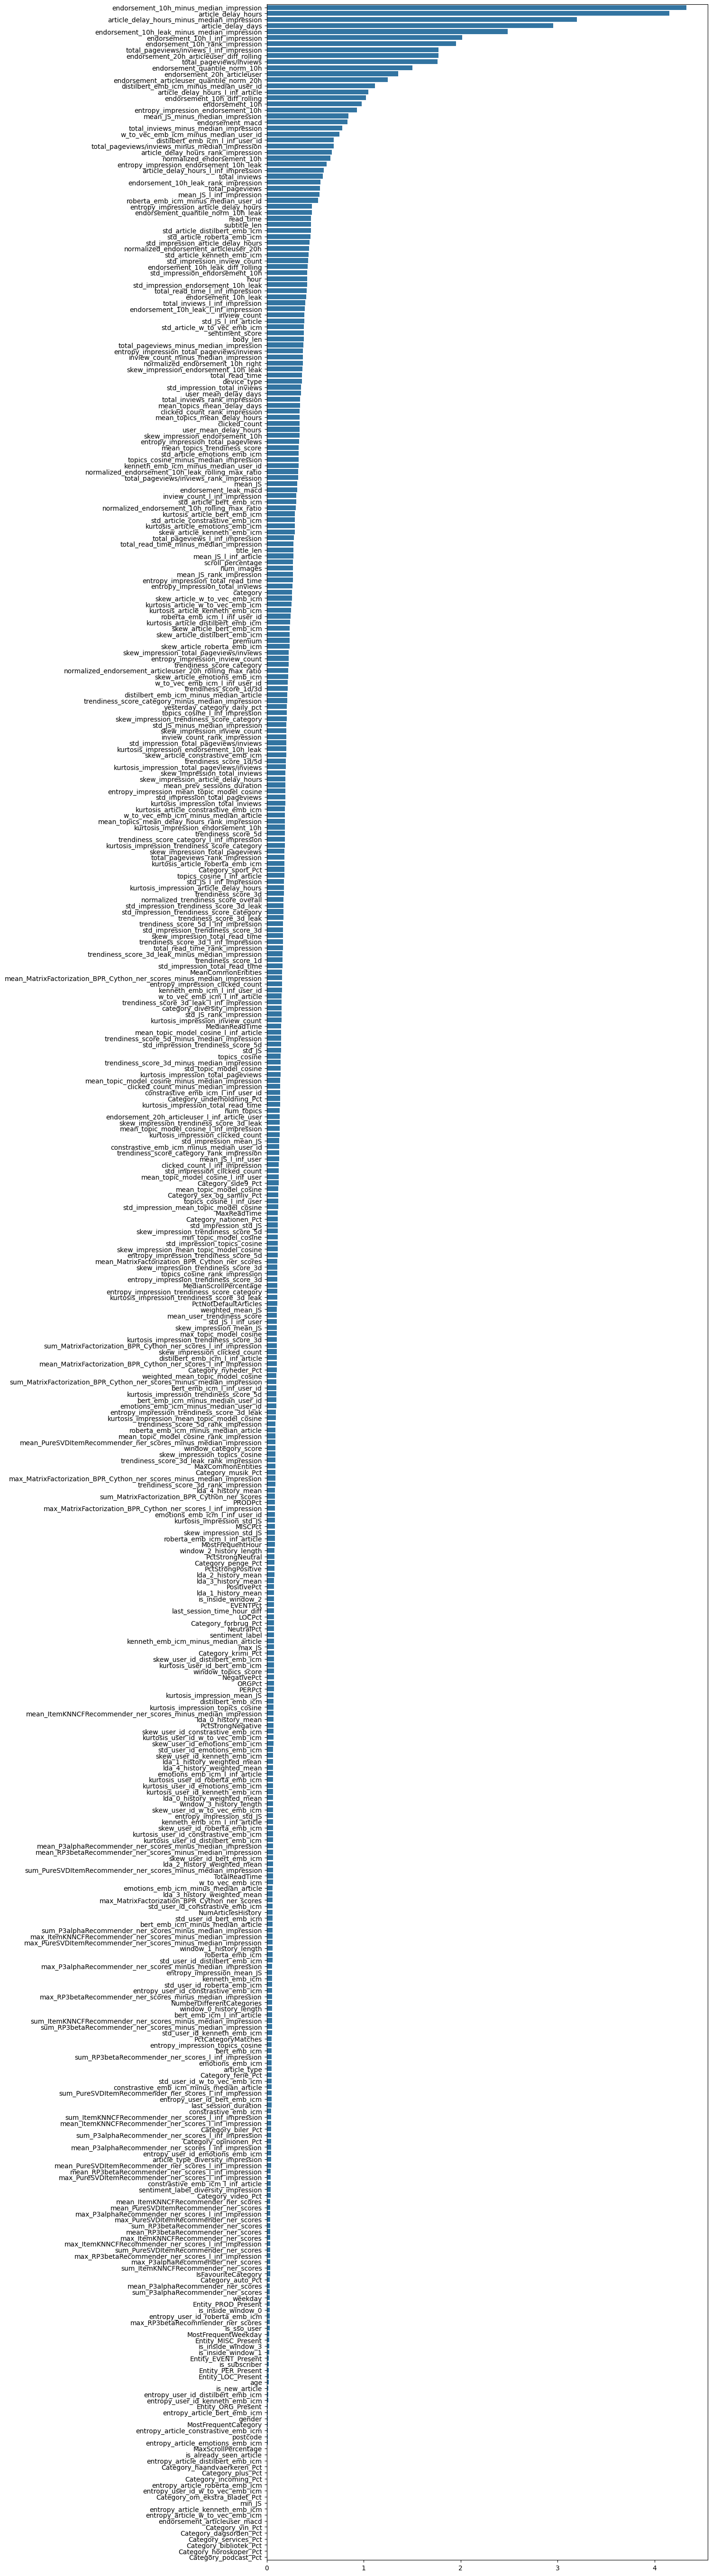

In [16]:
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = joblib.load('/home/ubuntu/tmp_dataset/ner/catboost_ner_embeddings/model.joblib')

fi = model.feature_importances_
fn = model.feature_names_

sorted_indices = np.argsort(fi)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 70))
sns.barplot(x=fi[sorted_indices], y=np.array(fn)[sorted_indices])